In [2]:
import numpy as np
np.random.seed(0)

import tensorflow as tf
try:
    tf.get_logger().setLevel('INFO')
except Exception as exc:
    print(exc)
import warnings
warnings.simplefilter("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import ray
from ray import tune
from ray.tune.examples.utils import get_iris_data

import inspect
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
# 1. Visualize the Data

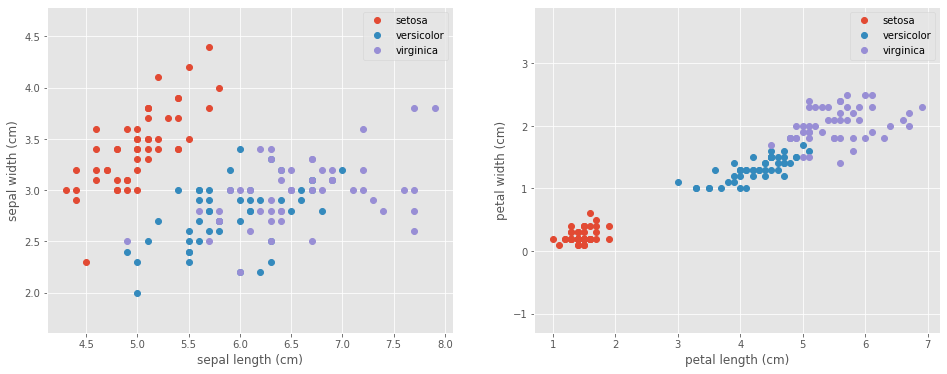

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
true_data = iris['data']
true_label = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

def plot_data(X, y):
    # Visualize the data sets
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for target, target_name in enumerate(names):
        X_plot = X[y == target]
        plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.axis('equal')
    plt.legend();

    plt.subplot(1, 2, 2)
    for target, target_name in enumerate(names):
        X_plot = X[y == target]
        plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
    plt.xlabel(feature_names[2])
    plt.ylabel(feature_names[3])
    plt.axis('equal')
    plt.legend();
    
plot_data(true_data, true_label)

# 2. Creating a Model

In [4]:
def create_model(learning_rate, dense_1, dense_2):
    assert learning_rate > 0 and dense_1 > 0 and dense_2 > 0, "Did you set the right configuration?"
    model = Sequential()
    model.add(Dense(int(dense_1), input_shape=(4,), activation='relu', name='fc1'))
    model.add(Dense(int(dense_2), activation='relu', name='fc2'))
    model.add(Dense(3, activation='softmax', name='output'))
    optimizer = SGD(lr=learning_rate)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
def train_on_iris():
    train_x, train_y, test_x, test_y = get_iris_data()
    model = create_model(learning_rate=0.1, dense_1=2, dense_2=2)
    # This saves the top model. `accuracy` is only available in TF2.0.
    checkpoint_callback = ModelCheckpoint(
        "model.h5", monitor='accuracy', save_best_only=True, save_freq=2)

    # Train the model
    model.fit(
        train_x, train_y, 
        validation_data=(test_x, test_y),
        verbose=0, batch_size=10, epochs=20, callbacks=[checkpoint_callback])
    return model

In [6]:
original_model = train_on_iris()  # This trains the model and returns it.
train_x, train_y, test_x, test_y = get_iris_data()
original_loss, original_accuracy = original_model.evaluate(test_x, test_y, verbose=0)
print("Loss is {:0.4f}".format(original_loss))
print("Accuracy is {:0.4f}".format(original_accuracy))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loss is 1.1352
Accuracy is 0.2105


# 3. Integrate with Tune

In [7]:
import tensorflow.keras as keras
from ray.tune import track


class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        track.log(keras_info=logs, mean_accuracy=logs.get("accuracy"), mean_loss=logs.get("loss"))


In [8]:
def tune_iris(config):  # TODO: Change me.
    train_x, train_y, test_x, test_y = get_iris_data()
    model = create_model(learning_rate=config["lr"], dense_1=config["dense_1"], dense_2=config["dense_2"])  # TODO: Change me.
    checkpoint_callback = ModelCheckpoint(
        "model.h5", monitor='loss', save_best_only=True, save_freq=2)

    # Enable Tune to make intermediate decisions by using a Tune Callback hook. This is Keras specific.
    callbacks = [checkpoint_callback, TuneReporterCallback()]
    
    # Train the model
    model.fit(
        train_x, train_y, 
        validation_data=(test_x, test_y),
        verbose=0, 
        batch_size=10, 
        epochs=20, 
        callbacks=callbacks)
    
assert len(inspect.getargspec(tune_iris).args) == 1, "The `tune_iris` function needs to take in the arg `config`."

print("Test-running to make sure this function will run correctly.")
tune.track.init()  # For testing purposes only.
tune_iris({"lr": 0.1, "dense_1": 4, "dense_2": 4})
print("Success!")

Test-running to make sure this function will run correctly.
Success!


# 4. Launching Hyperparameter Search

In [9]:
# This seeds the hyperparameter sampling.
import numpy as np; np.random.seed(5)  
hyperparameter_space = {
    "lr": tune.loguniform(0.001, 0.1),
    "dense_1": tune.uniform(2, 128),
    "dense_2": tune.uniform(2, 128)
}  # TODO: Fill me out.
num_samples = 20  # TODO: Fill me out.

####################################################################################################
################ This is just a validation function for tutorial purposes only. ####################
HP_KEYS = ["lr", "dense_1", "dense_2"]
assert all(key in hyperparameter_space for key in HP_KEYS), (
    "The hyperparameter space is not fully designated. It must include all of {}".format(HP_KEYS))
######################################################################################################

ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)
# We clean out the logs before running for a clean visualization later.
! rm -rf ~/ray_results/tune_iris

analysis = tune.run(
    tune_iris, 
    verbose=1, 
    config=hyperparameter_space,
    num_samples=num_samples)

assert len(analysis.trials) == 20, "Did you set the correct number of samples?"

Trial name,status,loc,lr,dense_1,dense_2,iter,total time (s),loss
tune_iris_bf088fbc,TERMINATED,,0.00277963,111.712,28.0466,19,12.5304,0.640618
tune_iris_bf099876,TERMINATED,,0.0687419,63.5398,79.0797,19,10.1949,0.424887
tune_iris_bf0a1c4c,TERMINATED,,0.0340264,67.3207,39.3969,19,10.1818,0.210863
tune_iris_bf0b4086,TERMINATED,,0.00237379,12.1734,95.0435,19,9.87871,0.947534
tune_iris_bf0c3180,TERMINATED,,0.00763165,21.947,112.872,19,11.0909,0.354005
tune_iris_bf0ceaee,TERMINATED,,0.00353324,54.1936,39.3061,19,12.0324,0.592756
tune_iris_bf0e5b22,TERMINATED,,0.0180957,75.0596,77.5911,19,10.5509,0.249845
tune_iris_bf0f316e,TERMINATED,,0.00340125,37.8704,33.9521,19,12.0627,0.580028
tune_iris_bf10a24c,TERMINATED,,0.00451989,20.1647,22.8672,19,9.15338,0.422794
tune_iris_bf120e70,TERMINATED,,0.0846956,122.989,25.7402,19,12.1123,0.341292


2019-12-22 12:17:23,164	INFO tune.py:334 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


# 5. Analyse the Best Tuned Model

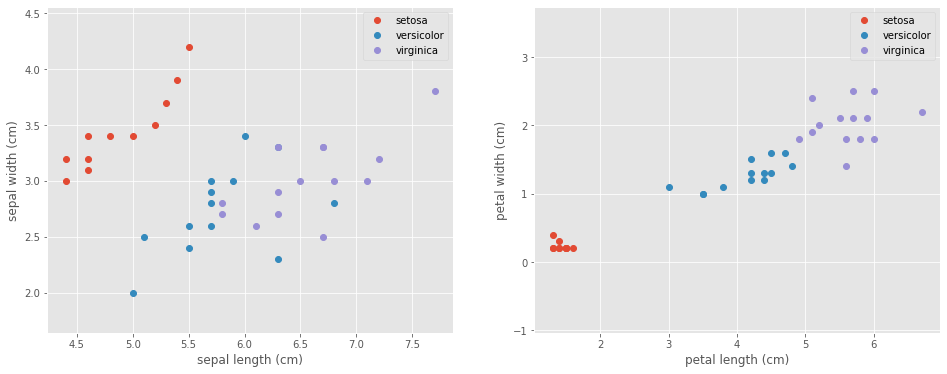

In [10]:
_, _, test_data, test_labels = get_iris_data()
plot_data(test_data, test_labels.argmax(1))

You can use any of the following columns to get the best model: 
['keras_info/loss', 'keras_info/acc', 'keras_info/val_loss', 'keras_info/val_acc'].
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loss is 0.2984
Tuned accuracy is 0.8947
The original un-tuned model had an accuracy of 0.2105


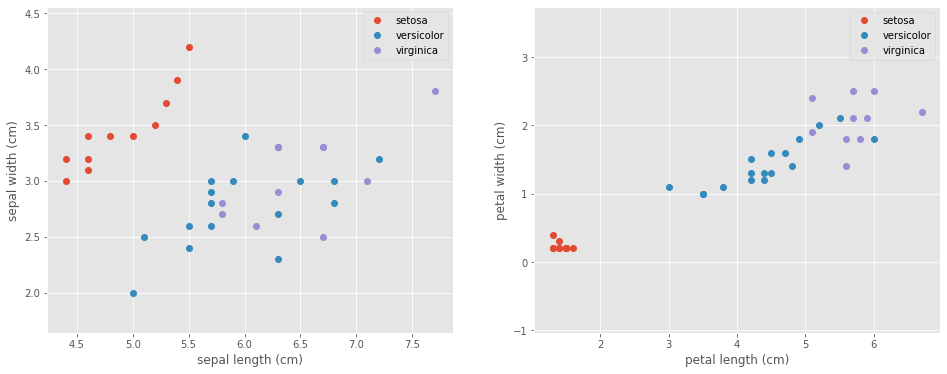

In [11]:
# Obtain the directory where the best model is saved.
print("You can use any of the following columns to get the best model: \n{}.".format(
    [k for k in analysis.dataframe() if k.startswith("keras_info")]))
print("=" * 10)
logdir = analysis.get_best_logdir("keras_info/val_loss", mode="min")
# We saved the model as `model.h5` in the logdir of the trial.
from tensorflow.keras.models import load_model
tuned_model = load_model(logdir + "/model.h5")

tuned_loss, tuned_accuracy = tuned_model.evaluate(test_data, test_labels, verbose=0)
print("Loss is {:0.4f}".format(tuned_loss))
print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
print("The original un-tuned model had an accuracy of {:0.4f}".format(original_accuracy))
predicted_label = tuned_model.predict(test_data)
plot_data(test_data, predicted_label.argmax(1))

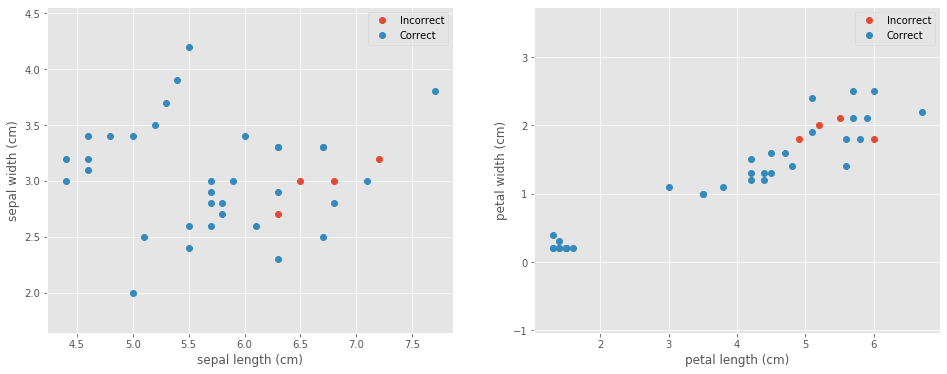

In [12]:
def plot_comparison(X, y):
    # Visualize the data sets
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for target, target_name in enumerate(["Incorrect", "Correct"]):
        X_plot = X[y == target]
        plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.axis('equal')
    plt.legend();

    plt.subplot(1, 2, 2)
    for target, target_name in enumerate(["Incorrect", "Correct"]):
        X_plot = X[y == target]
        plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
    plt.xlabel(feature_names[2])
    plt.ylabel(feature_names[3])
    plt.axis('equal')
    plt.legend();
    
plot_comparison(test_data, test_labels.argmax(1) == predicted_label.argmax(1))